<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/Efficient_Net_test_colab_230521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [4]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/X_train_update.csv',index_col=0)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/Y_train_CVw08PX.csv',index_col=0)

In [ ]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image name']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:1600,:]
y_val = y_train.iloc[:1600,:]
X_train = X_train.iloc[:14400,:]
y_train = y_train.iloc[:14400:,:]
X_test = X_test.iloc[:4000,:]
y_test = y_test.iloc[:4000,:]

In [9]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [14]:
batch_size = 32
path = '/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/images tests/image_train'
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224), batch_size = batch_size)
val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val, directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224),batch_size = batch_size)
test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test, directory=path, x_col = "image name", y_col = "class", class_mode ="sparse", target_size = (224, 224), batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="image name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 14397 validated image filenames belonging to 27 classes.
Found 1600 validated image filenames belonging to 27 classes.
Found 4000 validated image filenames belonging to 27 classes.


In [16]:
pip install -U efficientnet

     |████████████████████████████████| 51kB 1.7MB/s 


In [17]:
import efficientnet.keras as efn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D

In [18]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

    
n_class = 27
 
model = Sequential()
model.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation="sigmoid"))

from tensorflow.keras.optimizers import RMSprop
 
# Compiling the model
model.compile(RMSprop(lr=0.0001, decay=1e-6),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

16809984/16804768 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                27675     
Total params: 68,303,543
Trainable params: 68,261,527
Non-trainable params: 42,016
_________________________________________________________________


In [19]:
# Training the model for 10 epochs
history = model.fit_generator(train_generator, 
                                epochs = 5,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
450/450 [==============================] - 10509s 23s/step - loss: 3.3036 - accuracy: 0.1828 - val_loss: 2.3110 - val_accuracy: 0.3537
Epoch 2/5
450/450 [==============================] - 252s 560ms/step - loss: 2.5065 - accuracy: 0.2967 - val_loss: 2.1065 - val_accuracy: 0.3900
Epoch 3/5
450/450 [==============================] - 254s 564ms/step - loss: 2.3379 - accuracy: 0.3405 - val_loss: 2.0994 - val_accuracy: 0.4006
Epoch 4/5
450/450 [==============================] - 252s 560ms/step - loss: 2.2730 - accuracy: 0.3561 - val_loss: 1.9340 - val_accuracy: 0.4412
Epoch 5/5
450/450 [==============================] - 252s 560ms/step - loss: 2.2020 - accuracy: 0.3781 - val_loss: 1.9290 - val_accuracy: 0.4481


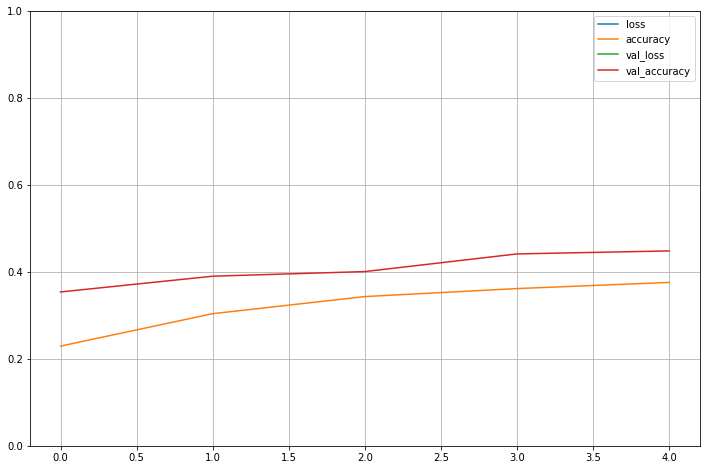

In [20]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()